# Sujet PLDAC : Interpolation contextualisée


<u>**Enseignants**</u>: Vincent Guigue & Nicolas Baskiotis

-------------

<u>**Contexte :**<br/></u>
L’idée est de développer des algorithmes prédictifs et d’interpolation sur les trajectoires
GPS de voiture.<br/>
En effet, la plupart des traces disponibles sont en très bas échantillonnage... Ce qui bride de nombreuses application.<br/>
A partir d’un ensemble de données *T* = {x<sub>1</sub>, ... , x<sub>t</sub>, ..  , x<sub>T</sub>} ∈ *R<sup>2×T</sup>*, il est possible de
chercher à prédire *x<sub>T+1</sub>* : cela constitue un problème classique.<br/> Il est aussi possible de chercher
à prédire *x<sub>t+1/2</sub>* qui se situe entre les pas de temps *t* et *t+1*.<br/>
Nous nous intéressons à ces problèmes... Mais en ajoutant un ingrédient important :
la connaissance du contexte. En effet, à certaines intersections, on peut trouver à partir
des observations du passé que tout le monde tourne à gauche : sachant cela, les problèmes
précédents deviennent plus faciles.<br/>
A partir d’une base des traces GPS haute fréquence sur la ville de Détroit, le but est
d’apprendre à la fois les modèles de prédiction/interpolation et une représentation du contexte
spatial.

------------

### Description rapide

**Fichier:  DataGpsDas.csv**<br>
Source : https://catalog.data.gov/dataset/safety-pilot-model-deployment-data <br/>

-------------------------

**Nombre de lignes total dans le fichier :** 41021227 <br/>
**Nombre de colonnes :** 17

------------------------

**Nom des colonnes :**   ['Device', 'Trip', 'Time', 'GpsTime', 'GpsWeek', 'GpsHeading',
       'GpsSpeed', 'Latitude', 'Longitude', 'Altitude', 'NumberOfSats',
       'Differential', 'FixMode', 'Pdop', 'GpsBytes', 'UtcTime', 'UtcWeek']

-----------------------

<U>**Description de quelques colonnes :**</U>




**Attribute Label:  DeviceID (column 1)** <br/>
**Attribute Definition:** This field contains the unique, numeric ID assigned to each DAS. This ID also doubles as a vehicle’s ID. <br/>
**Attribute Domain Values:** Integer <br/>

-----------------------

**Attribute Label: Trip (column 2)** <br/>
**Attribute Definition:** This field contains a count of ignition cycles—each ignition cycle commences when the ignition is in the on position and ends when it is in the off position. <br/>
**Attribute Domain Values:** Integer<br/>

----------------------

**Attribute Label: Time (column 3)** <br/>
**Attribute Definition:** This field contains the time in centiseconds since DAS started, which (generally) starts when the ignition is in the on position. <br/>
**Attribute Domain Values:** Integer

----------------------

**Attribute Label: GPS_Speed  (column 7)** <br/>
**Attribute Definition:** This field contains the speed, in meters/second, of vehicle according to GPS. <br/>
**Attribute Domain Values:** Float

---------------------

**Attribute Label: GPS_Latitude (column 8)** <br/> 
**Attribute Definition:** This field contains the latitude, in degrees, of vehicle according to GPS.<br/> 
**Attribute Domain Values:** Float 

---------------------

**Attribute Label: GPS_Longitude (column 9)**<br/>
**Attribute Definition:** This field contains the longitude, in degrees, of vehicle according to GPS.<br/>
**Attribute Domain Values:** Float 

---------------------

**Attribute Label: GPS_Pdop  (column 14)** <br/>
**Attribute Definition:** This field contains the Positional Dilution of Precision, used to determine position accuracy; the lower the number, the better. <br/>
**Attribute Domain Values:** Float <br/>

### Importation de librairies

In [199]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Lecture du fichier

In [200]:
# lecture du fichier csv : 1.000.000 premières lignes
df = pd.read_csv("DataGpsDas.csv", nrows=1000000)

### Trie des données

Informations tirées du pdf *Motion ResNet : An efficient data imputation method for spatio-temporal series* :

1. "We took trajectories only passing in a defined perimeter centered in latitude 42.282970 and longitude -83.735390, all positions within **latitude 42.282970±0.003000** and **longitude −83.735390±0.003000** are kept."


2. "Also we keep only trajectories with **at least 100 data points** so that we have enough dynamics to learn something."

In [201]:
#1.
df = df[(df["Latitude"] >= 42.282970-0.003) & (df["Latitude"] <= 42.282970+0.003) 
        & (df["Longitude"] >= -83.735390-0.003) & (df["Longitude"] <= -83.735390+0.003)]

#2.
trips, counts = np.unique(df["Trip"], return_counts=True)
trips = trips[counts>100]
df = df[df['Trip'].isin(trips)]

#affichage du dataframe
df

,Device,Trip,Time,GpsTime,GpsWeek,GpsHeading,GpsSpeed,Latitude,Longitude,Altitude,NumberOfSats,Differential,FixMode,Pdop,GpsBytes,UtcTime,UtcWeek
120957,10204,268,72571,506824400,1708,239.485600,7.54,42.285965,-83.733940,212.93100,12,1,4,1.32,4,506808400,1708
120958,10204,268,72591,506824600,1708,239.828290,7.49,42.285957,-83.733955,212.98801,13,1,4,1.30,4,506808600,1708
120959,10204,268,72612,506824800,1708,239.733800,7.42,42.285954,-83.733971,213.04300,13,1,4,1.30,4,506808800,1708
120960,10204,268,72633,506825000,1708,239.743190,7.42,42.285946,-83.733986,213.08299,13,1,4,1.30,10,506809000,1708
120961,10204,268,72652,506825200,1708,239.775100,7.38,42.285938,-83.734001,213.12100,13,1,4,1.30,4,506809200,1708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997735,17101,28,1595811,492287200,1710,60.193279,11.00,42.285923,-83.733826,212.14600,11,1,4,1.58,4,492271200,1710
997736,17101,28,1595830,492287400,1710,60.422611,10.99,42.285934,-83.733803,212.07300,11,1,4,1.58,4,492271400,1710
997737,17101,28,1595851,492287600,1710,60.365929,10.98,42.285942,-83.733780,211.98599,11,1,4,1.58,4,492271600,1710
997738,17101,28,1595870,492287800,1710,60.441559,10.90,42.285954,-83.733749,211.89700,11,1,4,1.58,4,492271800,1710


### Exploration des données

Quelques statistiques de base sur certaines colonnes ...

In [202]:
colonnes = ['Time', 'GpsHeading', 'GpsSpeed','Latitude', 'Longitude', 'Altitude','Pdop']

df[colonnes].describe()

,Time,GpsHeading,GpsSpeed,Latitude,Longitude,Altitude,Pdop
count,3.537200e+04,35372.000000,35372.000000,35372.000000,35372.000000,35372.000000,35372.000000
mean,4.781673e+05,211.952805,5.031042,42.282868,-83.735335,229.294582,1.914650
std,4.307300e+05,93.302970,4.527492,0.001508,0.001193,10.643619,2.568222
min,8.866000e+03,0.000200,0.000000,42.279972,-83.738380,207.424000,1.230000
25%,1.670110e+05,175.623400,0.150000,42.281387,-83.735771,223.694757,1.530000
50%,3.488350e+05,209.716710,4.610000,42.283173,-83.735550,230.304000,1.690000
75%,6.752512e+05,268.795043,8.440000,42.283470,-83.734573,236.293000,1.980000
max,1.595894e+06,359.996490,17.170000,42.285969,-83.732391,304.120000,99.989998


Visualisations

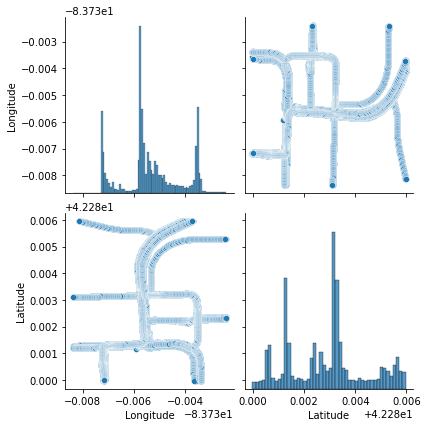

In [238]:
#Visualisation des colonnes Longitudes et Latitude
sns.pairplot(df[["Longitude", "Latitude"]], height=3)

<AxesSubplot:title={'center':'Distribution de la vitesse >0.05 du GPS'}, xlabel='GpsSpeed', ylabel='Count'>

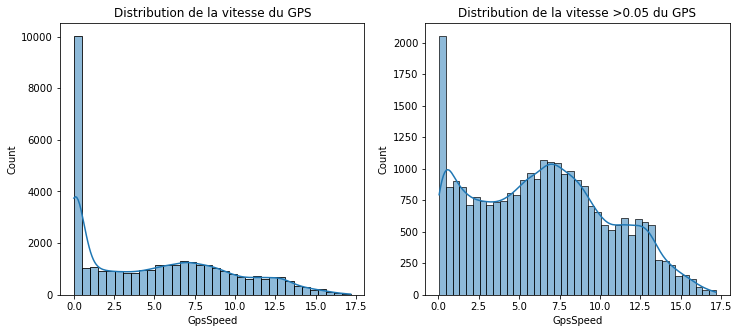

In [237]:
#Distribution de la vitesse du GPS pour la vitesse
fig, ax =plt.subplots(1,2, figsize=(12,5))
ax[0].set_title('Distribution de la vitesse du GPS')
sns.histplot(df["GpsSpeed"], kde=True, ax=ax[0])
ax[1].set_title('Distribution de la vitesse >0.05 du GPS')
sns.histplot(df.loc[df["GpsSpeed"]>0.05, "GpsSpeed"], kde=True, ax=ax[1])

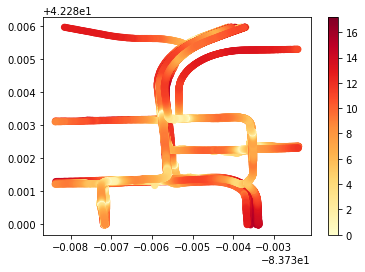

In [255]:
#fausse, à revoir plus tard
colonnes = ["GpsSpeed", "Longitude", "Latitude"]

p = plt.scatter(df["Longitude"], df["Latitude"], c=df["GpsSpeed"], cmap="YlOrRd")

plt.colorbar(p)

In [102]:
# modele physique
def nextpos(pos, alpha, v):
    return pos + alpha * v

datax = df.to_numpy()[:,5:7]

In [258]:
df.columns[5:7]

Index(['GpsHeading', 'GpsSpeed'], dtype='object')

In [256]:
def split_plan(df, n_interval):
    data = df.to_numpy() 
    # unpack dimension
    M, N = n_interval
    ub_x = data[:,1].max()
    lb_x = data[:,1].min()
    gap_x = (ub_x-lb_x)/M
    ub_y = data[:,2].max()
    lb_y = data[:,2].min()
    gap_y = (ub_y-lb_y)/N
    intervals_x = [lb_x + gap_x*k for k in range(1,M)]
    intervals_y = [lb_y + gap_y*k for k in range(1,N)]
    return intervals_x, intervals_y

def affectation(datax, intervals_x, intervals_y):
    M, N = datax.shape
    for i in range(M):
        x, y = datax[i,:]
        datax[i] = np.argmax(intervals_x>x), np.argmax(intervals_y>y)
    return datax

inter_x, inter_y = split_plan(df, (1000,2000))
raw_datay = affectation(datax, inter_x, inter_y)

In [ ]:
def to_labeled_points(raw_datay):
    # [0, 1, 2, 3, 4, 5, 6, 7, 8]
    #  rest, droite, hautdroite, haut, hautgauche, gauche, basgauche, bas, basdroite
    M = len(raw_datay)
    datay = np.zeros(M)
    for i in range(M):
        diff = (raw_datay[i+1] - raw_datay[i])
        if diff[0]>0:
            if diff[1]>0:
                grad = diff[1]/diff[0]
                if grad > 1:
                    data[y] = 
            
        else:

        datay[i] = datay[i,1]/datay[i,0]

    return data